# Ring broadcast experiment

In this experiment, N ranks perform a ring broadcast. We measure the duration of the individual calls to `MPI_Recv` and `MPI_Send`.

In [1]:
import io
import os
import zipfile
import pandas
import yaml
from plotnine import *
import plotnine
import sys
plotnine.options.figure_size = (12, 8)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # removing annoying Pandas warning

def read_csv(archive_name, csv_name, columns=None, filter_func=lambda x: x, usecols=None):
    archive = zipfile.ZipFile(archive_name)
    df= pandas.read_csv(io.BytesIO(filter_func(archive.read(csv_name))), names=columns)
    df.columns = df.columns.str.strip()
    return df

def get_yaml(archive_name, yaml_name):
    archive = zipfile.ZipFile(archive_name)
    return yaml.load(io.BytesIO(archive.read(yaml_name)), Loader=yaml.BaseLoader)

def load_ringrong(zip_name):
    df = read_csv(zip_name, 'result.csv').reset_index()
    df['msg_size'] = df['size']
    df.drop('size', inplace=True, axis=1)
    df['sub_id'] = df['index'] // 2 # identifying the MPI_Send and MPI_Recv that are part of a same ping-pong
    df['op_kind'] = df['sub_id'] % 2 # each rank makes two distincts ping-pong: one recv-send with the previous rank and one send-recv with the next rank
    df.loc[df['op_kind'] == 0, 'op_kind'] = 'recv-send'
    df.loc[df['op_kind'] == 1, 'op_kind'] = 'send-recv'
    remote_next = {31, 63}
    remote_prev = {0, 32}
    df.loc[df['rank'].isin(remote_prev) & (df['op_kind'] == 'recv-send'), 'experiment'] = 'remote'
    df.loc[~df['rank'].isin(remote_prev) & (df['op_kind'] == 'recv-send'), 'experiment'] = 'loopback'
    df.loc[df['rank'].isin(remote_next) & (df['op_kind'] == 'send-recv'), 'experiment'] = 'remote'
    df.loc[~df['rank'].isin(remote_next) & (df['op_kind'] == 'send-recv'), 'experiment'] = 'loopback'
    df_send = df[df['function'] == 'MPI_Send']
    df_recv = df[df['function'] == 'MPI_Recv']
    df_ringrong = df_send.set_index(['rank', 'op_id', 'sub_id', 'op_kind', 'experiment', 'msg_size']).join(df_recv.set_index(['rank', 'op_id', 'sub_id', 'op_kind', 'experiment', 'msg_size']), lsuffix='_send', rsuffix='_recv').reset_index()
    df_ringrong['duration'] = df_ringrong['duration_send'] + df_ringrong['duration_recv']
    info = get_yaml(zip_name, 'info.yaml')
    install = get_yaml(zip_name, info['installfile'])
    for df in [df_send, df_recv, df_ringrong]:
        df['cluster'] = info['cluster']
        df['matrix_size'] = int(install['matrix_size'])
    return {
        'ringrong': df_ringrong,
        'send': df_send,
        'recv': df_recv
    }

In [2]:
directory = 'ring/4/'
archives = [os.path.join(directory, f) for f in os.listdir(directory)]
df = pandas.concat([load_ringrong(f)['recv'] for f in archives])
df['matrix_size'] = pandas.Categorical(df['matrix_size'], categories=df[['matrix_size']].drop_duplicates().sort_values(by='matrix_size')['matrix_size'], ordered=True)
df

,index,function,rank,op_id,timestamp,duration,msg_size,sub_id,op_kind,experiment,cluster,matrix_size
1,1,MPI_Recv,0,0,0.000042,0.085322,8,0,recv-send,remote,gros,192
2,2,MPI_Recv,0,0,0.169956,0.000001,8,1,send-recv,loopback,gros,192
5,5,MPI_Recv,0,1,0.170003,0.001505,8,2,recv-send,remote,gros,192
6,6,MPI_Recv,0,1,0.236017,0.000001,8,3,send-recv,loopback,gros,192
9,9,MPI_Recv,0,2,0.236046,0.001481,8,4,recv-send,remote,gros,192
...,...,...,...,...,...,...,...,...,...,...,...,...
721911,721911,MPI_Recv,63,2817,7373.668512,0.002636,1002,360955,send-recv,remote,dahu,256
721912,721912,MPI_Recv,63,2818,7373.736425,0.000007,1002,360956,recv-send,loopback,dahu,256
721915,721915,MPI_Recv,63,2818,7373.736443,0.003174,1002,360957,send-recv,remote,dahu,256
721916,721916,MPI_Recv,63,2819,7373.807380,0.000005,1002,360958,recv-send,loopback,dahu,256


In [3]:
function = df['function'].unique()
assert len(function) == 1
function = function[0]
function

'MPI_Recv'

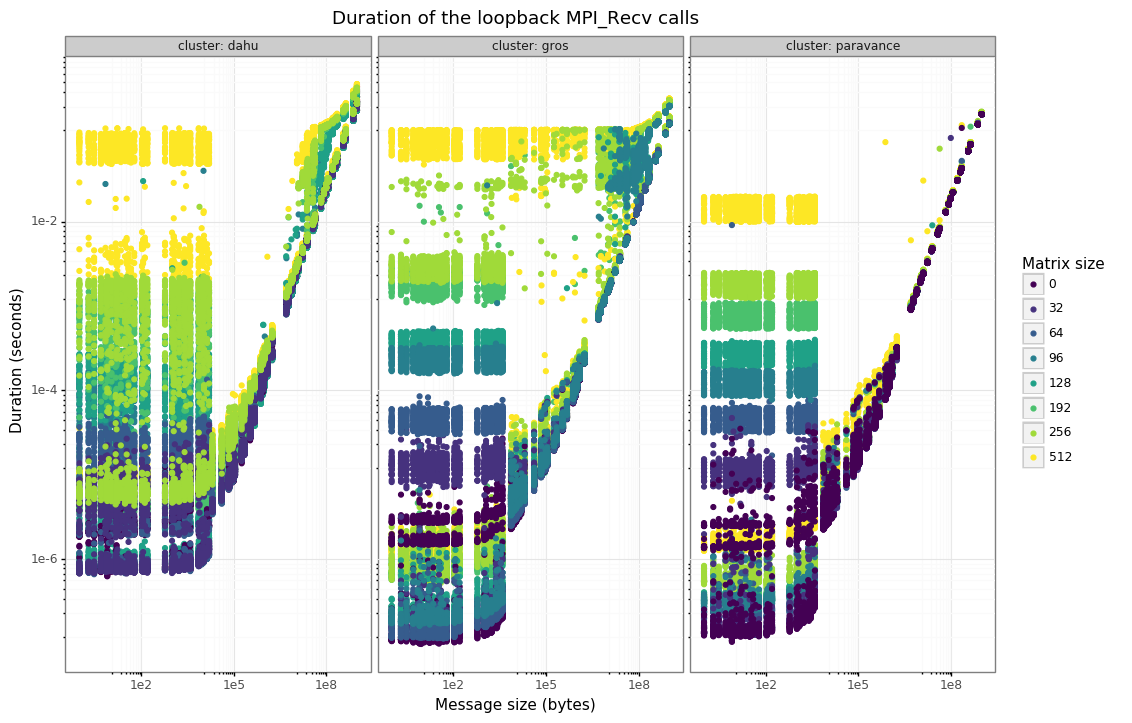

<ggplot: (-9223363242441715694)>

In [4]:
(ggplot(df[(df['rank'] == 3)])
    + aes(x='msg_size', y='duration', color='factor(matrix_size)')
    + geom_point() 
    + theme_bw()
    + scale_x_log10()
    + scale_y_log10()
    + facet_wrap('cluster', labeller='label_both')
    + labs(x='Message size (bytes)', y='Duration (seconds)', color='Matrix size')
    + ggtitle(f'Duration of the loopback {function} calls')
)

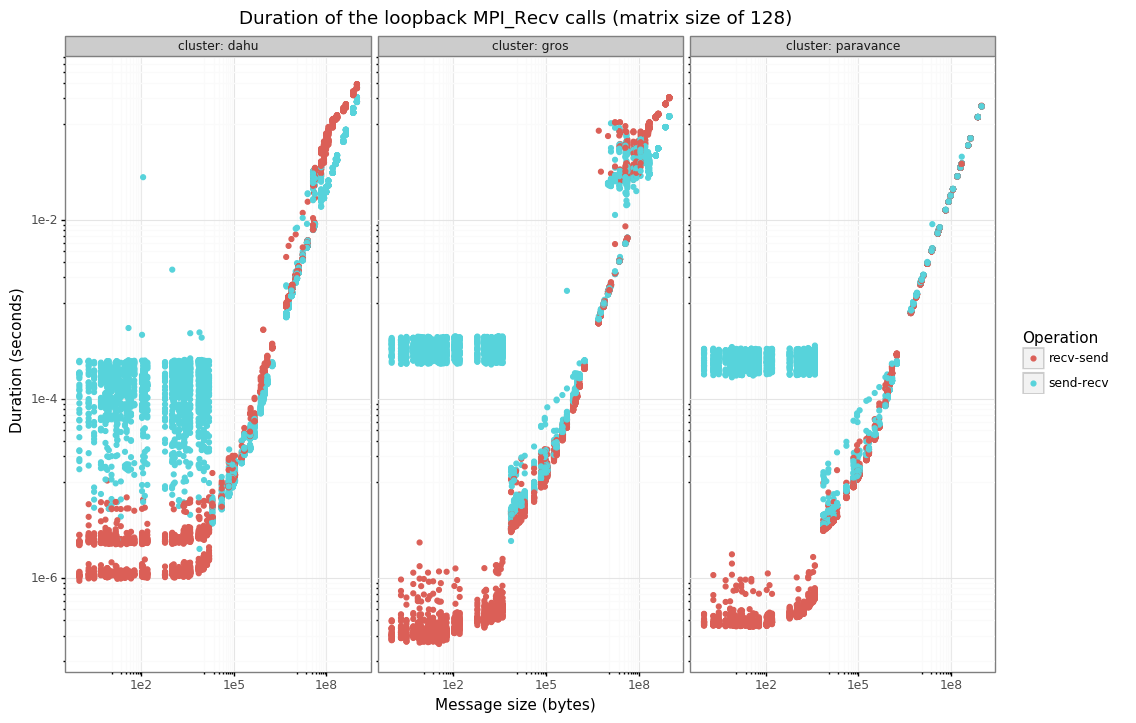

<ggplot: (8794414643162)>

In [5]:
(ggplot(df[(df['rank'] == 3) & (df['matrix_size'] == 128)])
    + aes(x='msg_size', y='duration', color='factor(op_kind)')
    + geom_point() 
    + theme_bw()
    + scale_x_log10()
    + scale_y_log10()
    + facet_wrap('cluster', labeller='label_both')
    + labs(x='Message size (bytes)', y='Duration (seconds)', color='Operation')
    + ggtitle(f'Duration of the loopback {function} calls (matrix size of 128)')
)

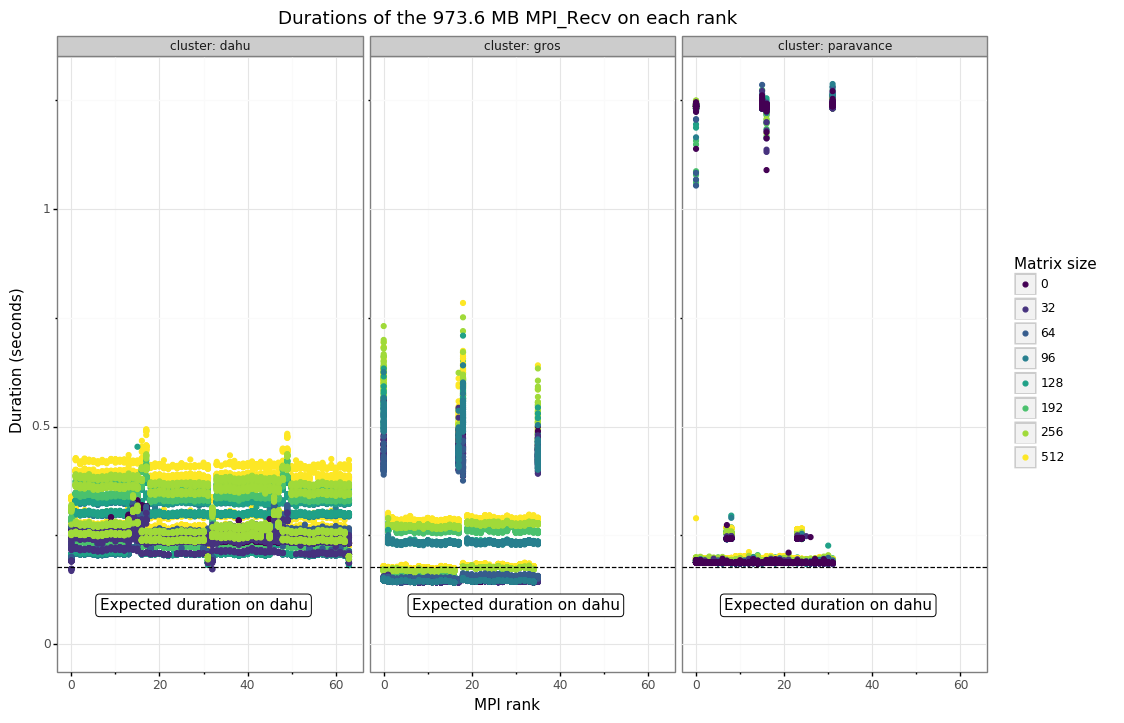

<ggplot: (8794415103503)>

In [6]:
df['size'] = df['msg_size']
bw  = 25*1e9
lat = 0.1*1e-6
bw_factor = 0.219
lat_factor = 0
size = df['size'].max()
theoretical_duration = size/(bw*bw_factor) + lat*lat_factor

(ggplot(df[df['size'] == size])
    + aes(x='rank', y='duration', color='matrix_size')
    + geom_point() 
    + theme_bw()
    + expand_limits(y=0)
    + geom_hline(yintercept=theoretical_duration, linetype='dashed')
    + facet_wrap('cluster', labeller='label_both')
    + labs(x='MPI rank', y='Duration (seconds)', color='Matrix size')
    + annotate('label', x=30, y=theoretical_duration*0.5, label='Expected duration on dahu')
    + ggtitle(f'Durations of the {size*1e-6:.1f} MB {function} on each rank')
)

221569716


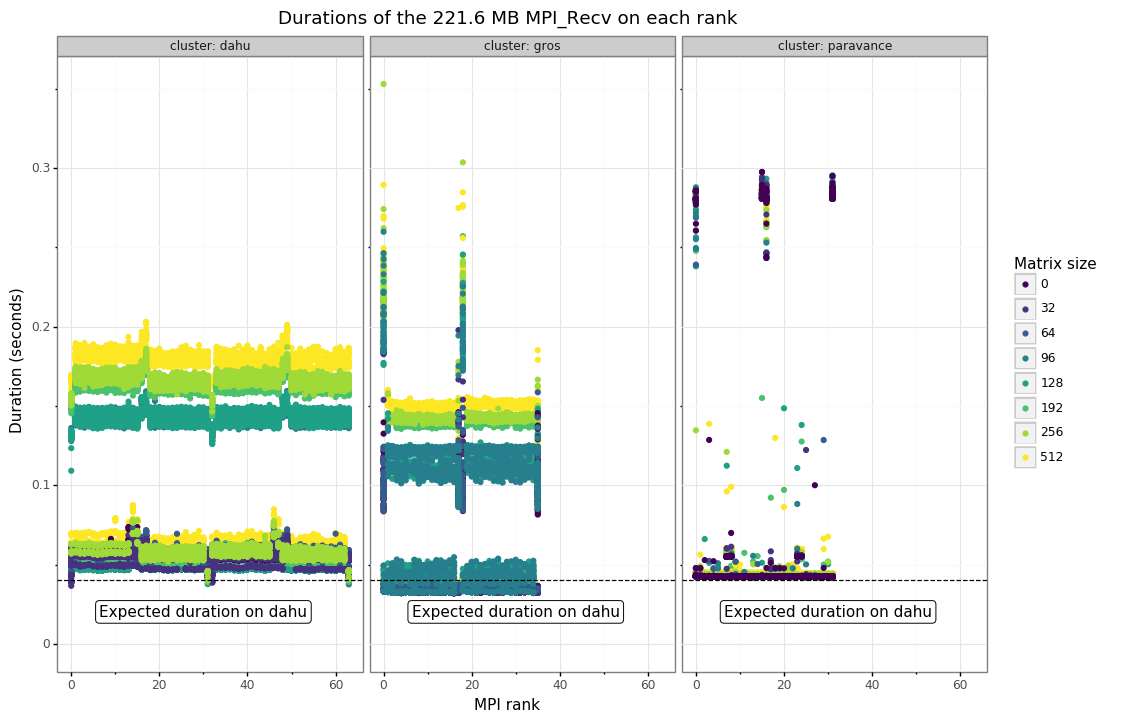

<ggplot: (8794414818389)>

In [7]:
bw  = 25*1e9
lat = 0.1*1e-6
bw_factor = 0.219
lat_factor = 0
size = df[df['size'] < 3e8]['size'].max()
print(size)
theoretical_duration = size/(bw*bw_factor) + lat*lat_factor

(ggplot(df[df['size'] == size])
    + aes(x='rank', y='duration', color='factor(matrix_size)')
    + geom_point() 
    + theme_bw()
    + expand_limits(y=0)
    + geom_hline(yintercept=theoretical_duration, linetype='dashed')
    + facet_wrap('cluster', labeller='label_both')
    + labs(x='MPI rank', y='Duration (seconds)', color='Matrix size')
    + annotate('label', x=30, y=theoretical_duration*0.5, label='Expected duration on dahu')
    + ggtitle(f'Durations of the {size*1e-6:.1f} MB {function} on each rank')
)

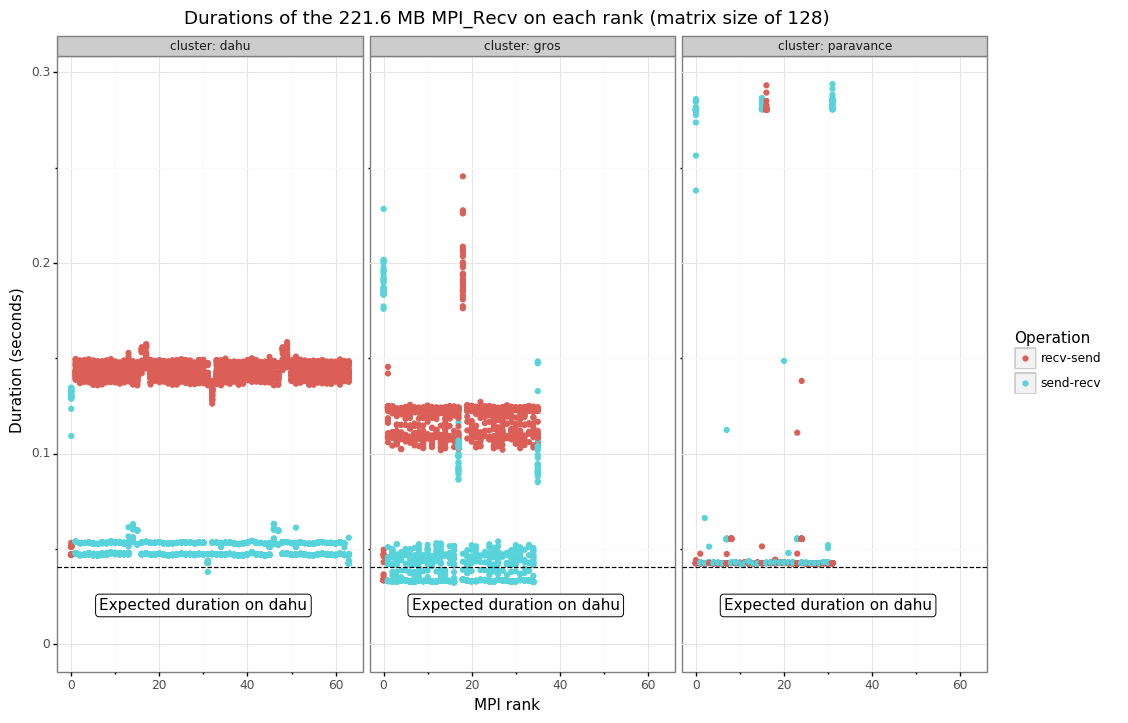

<ggplot: (-9223363242442475246)>

In [8]:
(ggplot(df[(df['size'] == size) & (df['matrix_size'] == 128)])
    + aes(x='rank', y='duration', color='factor(op_kind)')
    + geom_point() 
    + theme_bw()
    + expand_limits(y=0)
    + geom_hline(yintercept=theoretical_duration, linetype='dashed')
    + facet_wrap('cluster', labeller='label_both')
    + labs(x='MPI rank', y='Duration (seconds)', color='Operation')
    + annotate('label', x=30, y=theoretical_duration*0.5, label='Expected duration on dahu')
    + ggtitle(f'Durations of the {size*1e-6:.1f} MB {function} on each rank (matrix size of 128)')
)

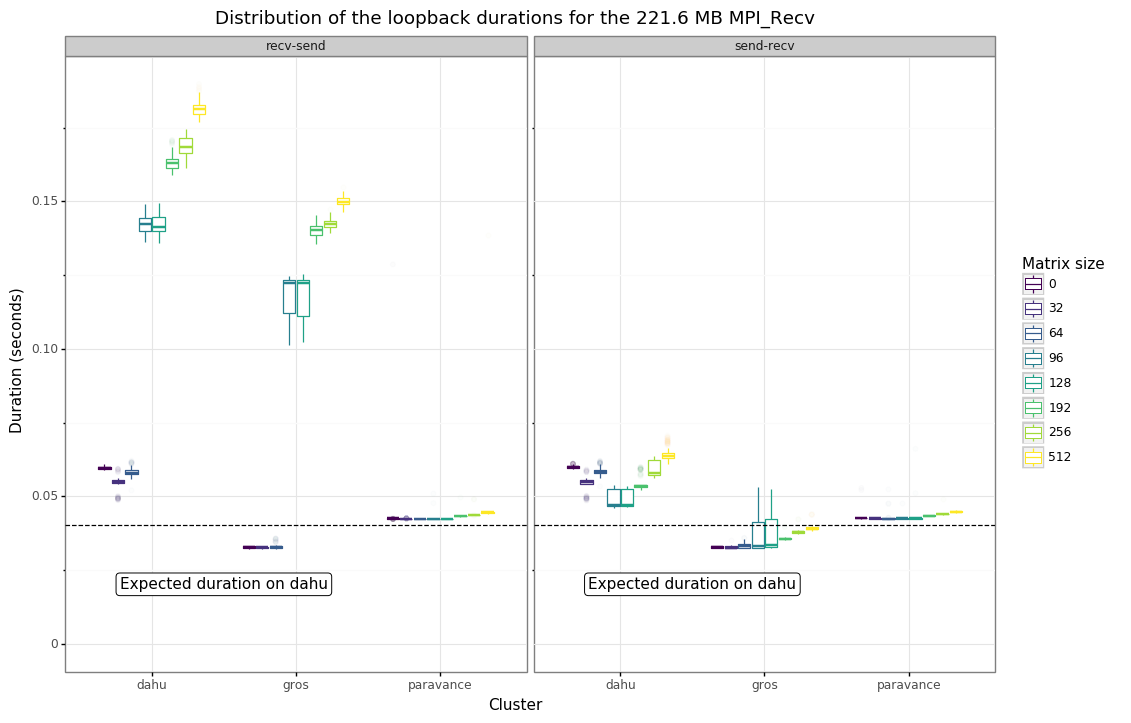

<ggplot: (-9223363242442473286)>

In [9]:
(ggplot(df[df['rank'].isin(range(2, 7)) & (df['size'] == size)])
        + aes(x='cluster', y='duration', color='factor(matrix_size)')
        + geom_boxplot(outlier_alpha=0.01)
        + theme_bw()
        + geom_hline(yintercept=theoretical_duration, linetype='dashed')
        + annotate('label', x=1.5, y=theoretical_duration*0.5, label='Expected duration on dahu')
        + labs(x='Cluster', y='Duration (seconds)', color='Matrix size')
        + facet_wrap('op_kind')
        + ggtitle(f'Distribution of the loopback durations for the {size*1e-6:.1f} MB {function}')
#        + guides(colour = guide_legend(override_aes = {'alpha': 1, 'size': 3}))
        + expand_limits(y=0)
)

## Monitoring

In [10]:
import cashew
print(cashew.__git_version__)
from cashew import archive_extraction

c0a430e3a498fc690b6244ca9909444040c28128


In [11]:
monitoring = []
for zip_name in archives:
    tmp = archive_extraction.read_monitoring(zip_name)
    info = get_yaml(zip_name, 'info.yaml')
    install = get_yaml(zip_name, info['installfile'])
    tmp['cluster'] = info['cluster']
    tmp['matrix_size'] = int(install['matrix_size'])
    monitoring.append(tmp)
monitoring = pandas.concat(monitoring)
monitoring['date'] = pandas.to_datetime(monitoring['start_time'], unit='s').astype(str)
for date in monitoring['date'].unique():
    monitoring.loc[monitoring['date'] == date, 'real_start_time'] = monitoring[monitoring['date'] == date]['timestamp'].min()
monitoring['start_exp'] -= monitoring['real_start_time']
monitoring['stop_exp'] -= monitoring['real_start_time']
monitoring['timestamp'] -= monitoring['real_start_time']
monitoring['cpu_id'] = monitoring['node'].astype(str) + ':' + monitoring['cpu'].astype(str)
monitoring['in_exp'] = (monitoring['timestamp'] > monitoring['start_exp'] + 60) & (monitoring['timestamp'] < monitoring['stop_exp'] - 60)
monitoring['hostname'] = monitoring['cluster'] + '-' + monitoring['node'].astype(str)
print(len(monitoring))
monitoring.head()

8739909


,timestamp,cluster,node,jobid,start_time,expfile_hash,value,cpu,core,kind,start_exp,stop_exp,matrix_size,date,real_start_time,cpu_id,in_exp,hostname
0,0.001012,gros,118,2695394,1598574742,6739f00b7ea525b20ae6f3cdd3202cc3835def4cbd026b...,3.178613,0,0,frequency,29.367831,4170.026232,192,2020-08-28 00:32:22,1.598582e+09,118:0,False,gros-118
1,1.006124,gros,118,2695394,1598574742,6739f00b7ea525b20ae6f3cdd3202cc3835def4cbd026b...,3.316516,0,0,frequency,29.367831,4170.026232,192,2020-08-28 00:32:22,1.598582e+09,118:0,False,gros-118
2,2.011616,gros,118,2695394,1598574742,6739f00b7ea525b20ae6f3cdd3202cc3835def4cbd026b...,2.977734,0,0,frequency,29.367831,4170.026232,192,2020-08-28 00:32:22,1.598582e+09,118:0,False,gros-118
3,3.018578,gros,118,2695394,1598574742,6739f00b7ea525b20ae6f3cdd3202cc3835def4cbd026b...,2.645263,0,0,frequency,29.367831,4170.026232,192,2020-08-28 00:32:22,1.598582e+09,118:0,False,gros-118
4,4.024151,gros,118,2695394,1598574742,6739f00b7ea525b20ae6f3cdd3202cc3835def4cbd026b...,1.431933,0,0,frequency,29.367831,4170.026232,192,2020-08-28 00:32:22,1.598582e+09,118:0,False,gros-118


In [12]:
monitoring['matrix_size'] = pandas.Categorical(monitoring['matrix_size'], categories=monitoring[['matrix_size']].drop_duplicates().sort_values(by='matrix_size')['matrix_size'], ordered=True)

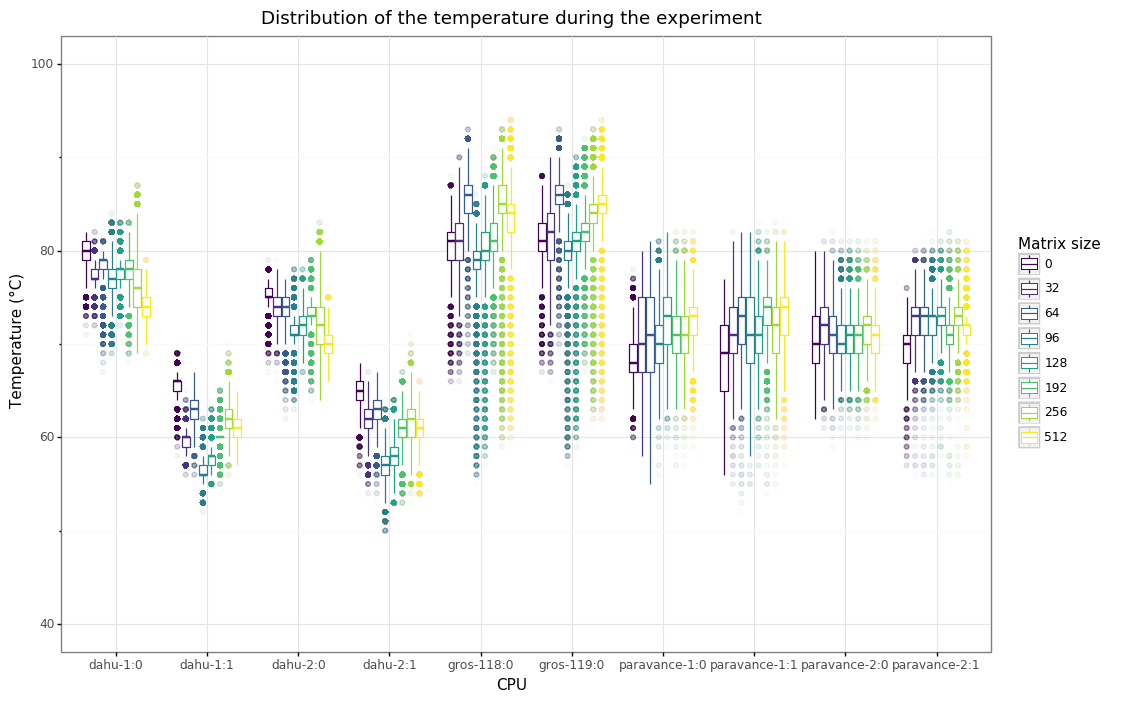

<ggplot: (8794411320328)>

In [13]:
monitoring['cpu_id'] = monitoring['hostname'] + ':' + monitoring['cpu'].astype(str)
(ggplot(monitoring[(monitoring.in_exp) & (monitoring.kind == 'temperature')])
        + aes(x='cpu_id', y='value', color='factor(matrix_size)')
        + geom_boxplot(outlier_alpha=0.01)
        + theme_bw()
        + labs(x='CPU', y='Temperature (°C)', color='Matrix size')
        + ggtitle(f'Distribution of the temperature during the experiment')
#        + guides(colour = guide_legend(override_aes = {'alpha': 1, 'size': 3}))
        + expand_limits(y=[40, 100])
)

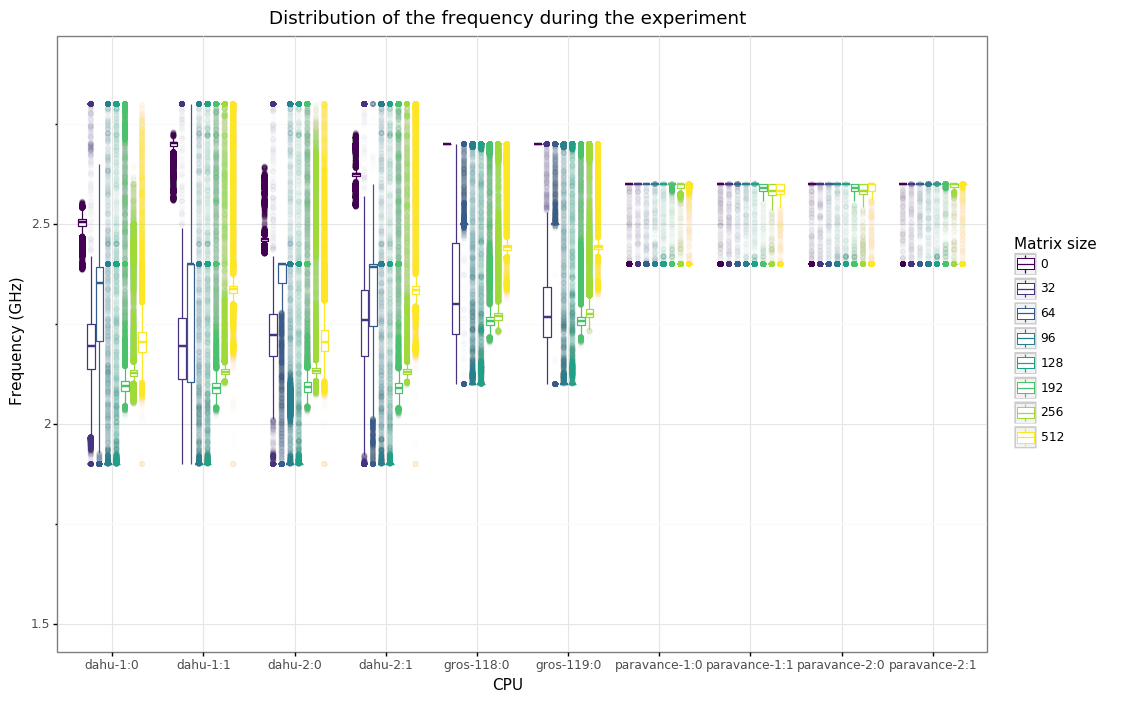

<ggplot: (-9223363242440238062)>

In [14]:
(ggplot(monitoring[(monitoring.in_exp) & (monitoring.kind == 'frequency')])
        + aes(x='cpu_id', y='value', color='factor(matrix_size)')
        + geom_boxplot(outlier_alpha=0.01)
        + theme_bw()
        + labs(x='CPU', y='Frequency (GHz)', color='Matrix size')
        + ggtitle(f'Distribution of the frequency during the experiment')
#        + guides(colour = guide_legend(override_aes = {'alpha': 1, 'size': 3}))
        + expand_limits(y=[1.5, 2.9])
)

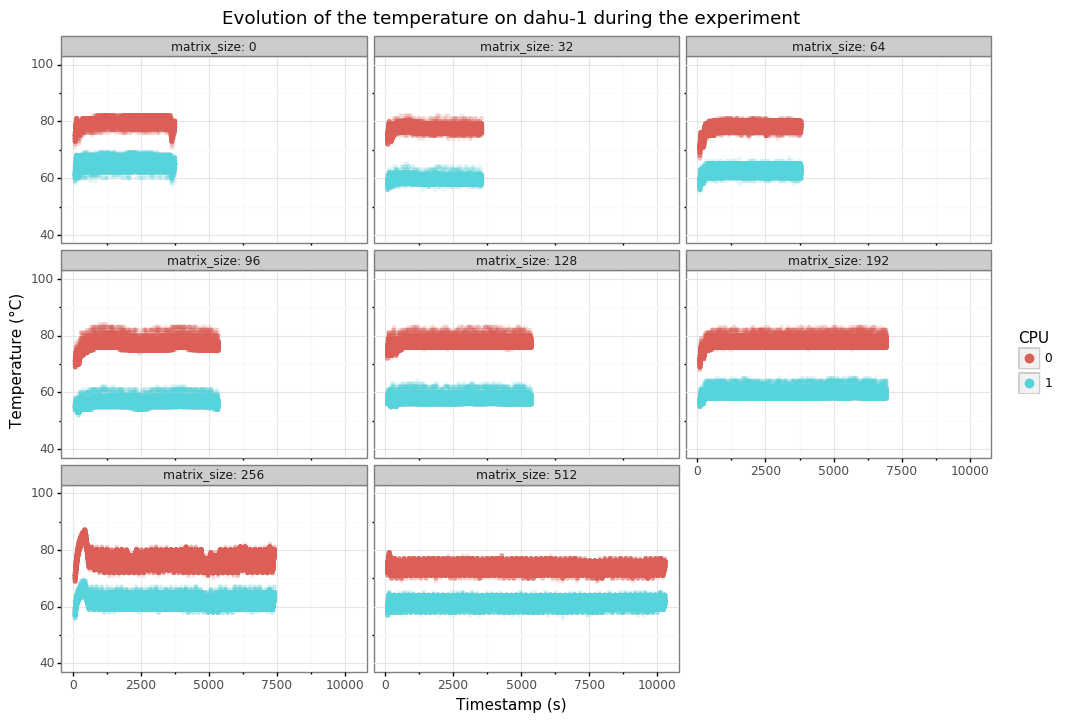

<ggplot: (8794306836477)>


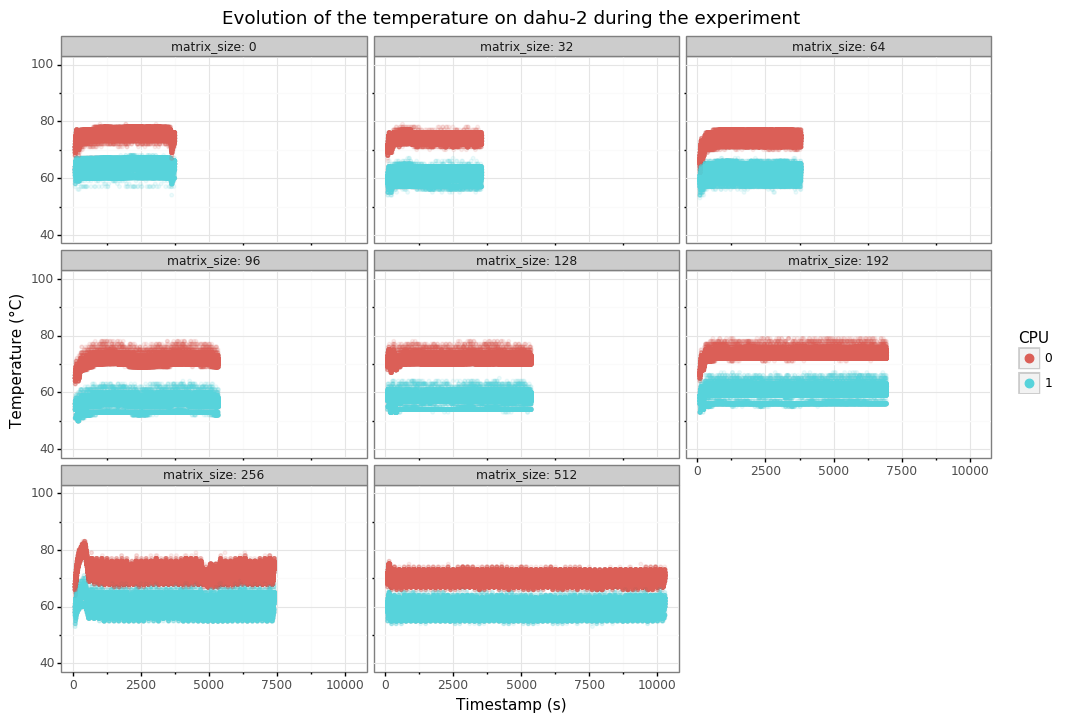

<ggplot: (-9223363242638678279)>


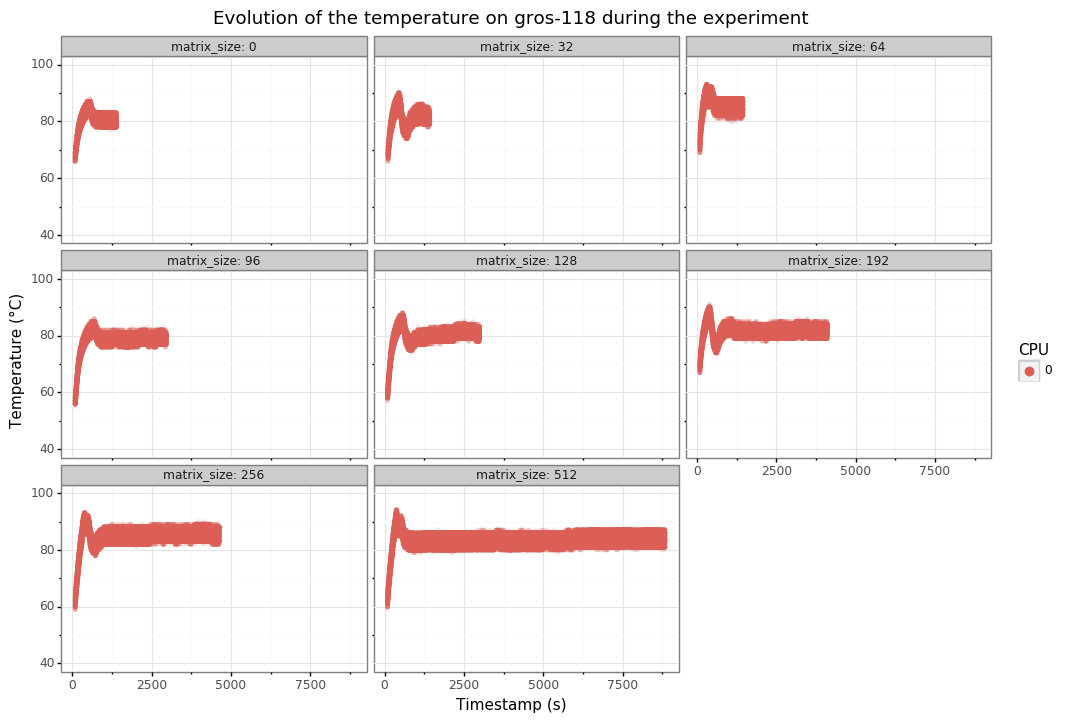

<ggplot: (-9223363242604215815)>


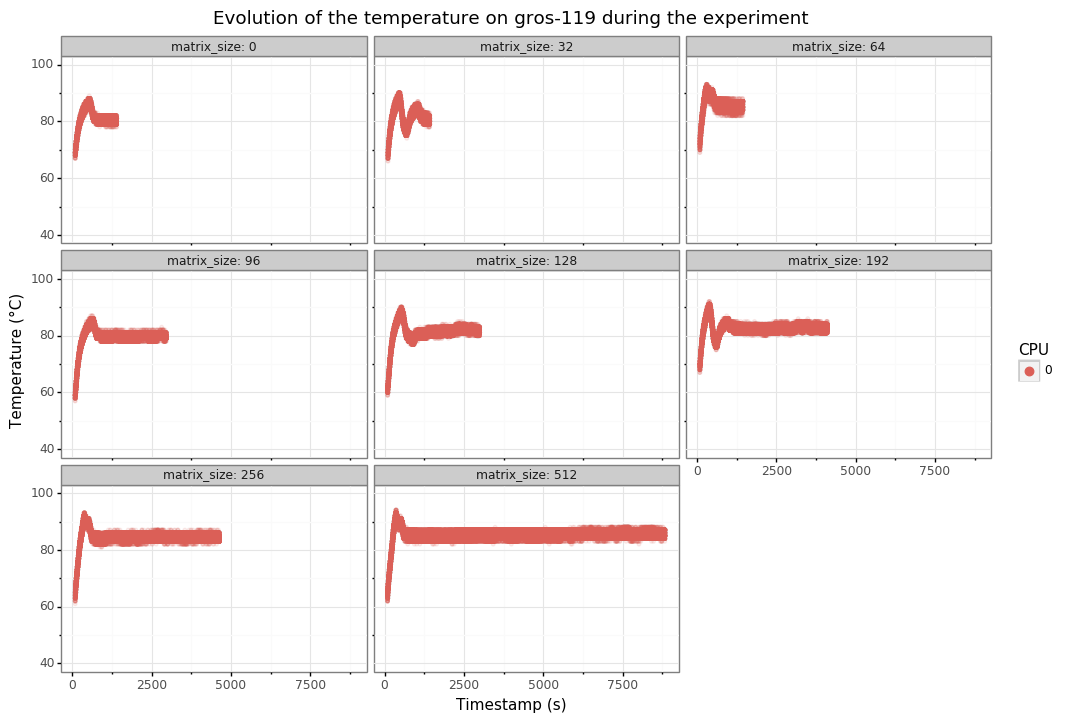

<ggplot: (8794248230141)>


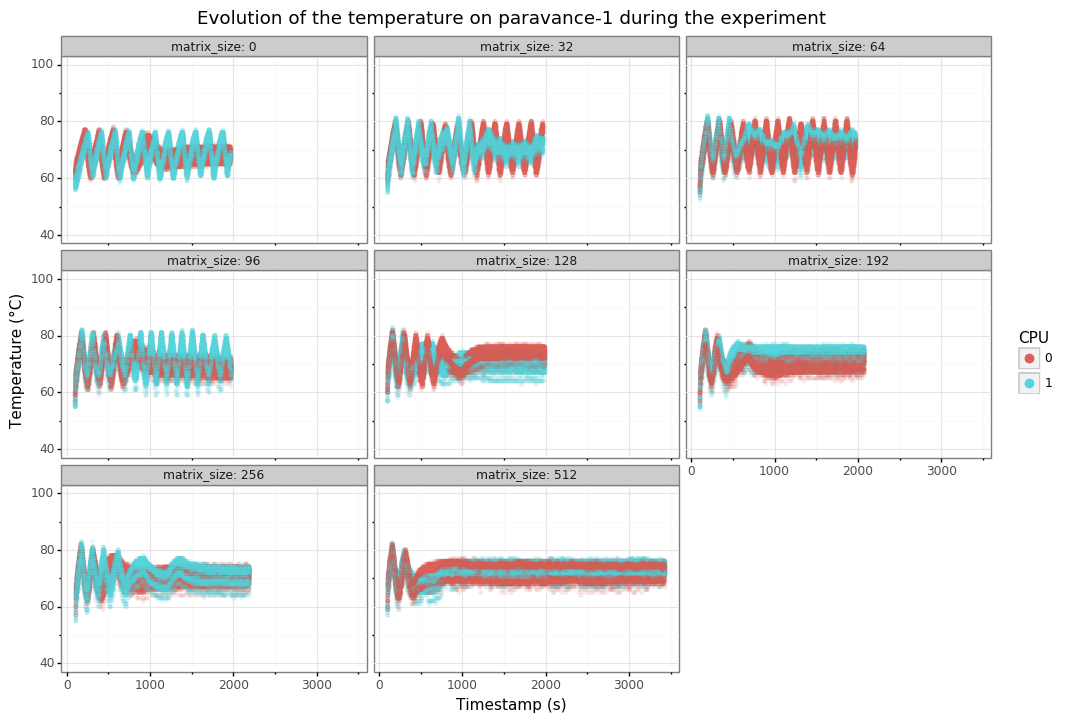

<ggplot: (8794306835990)>


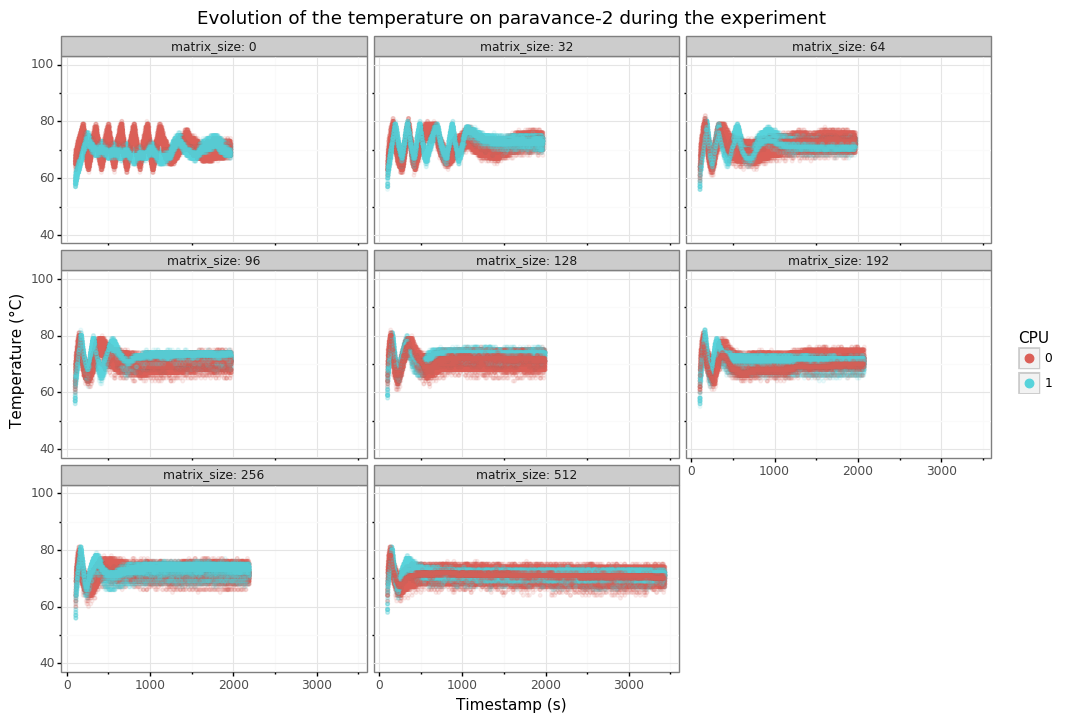

<ggplot: (8794188624118)>


In [15]:
for hostname in sorted(monitoring.hostname.unique()):
    print(ggplot(monitoring[(monitoring.in_exp) & (monitoring.hostname == hostname) & (monitoring.kind == 'temperature')])
        + aes(x='timestamp', y='value', color='factor(cpu)')
        + geom_point(alpha=0.1, size=1)
        + theme_bw()
        + labs(x='Timestamp (s)', y='Temperature (°C)', color='CPU')
        + ggtitle(f'Evolution of the temperature on {hostname} during the experiment')
        + guides(colour = guide_legend(override_aes = {'alpha': 1, 'size': 3}))
        + expand_limits(y=[40, 100])
        + facet_wrap('matrix_size', labeller='label_both')
    )

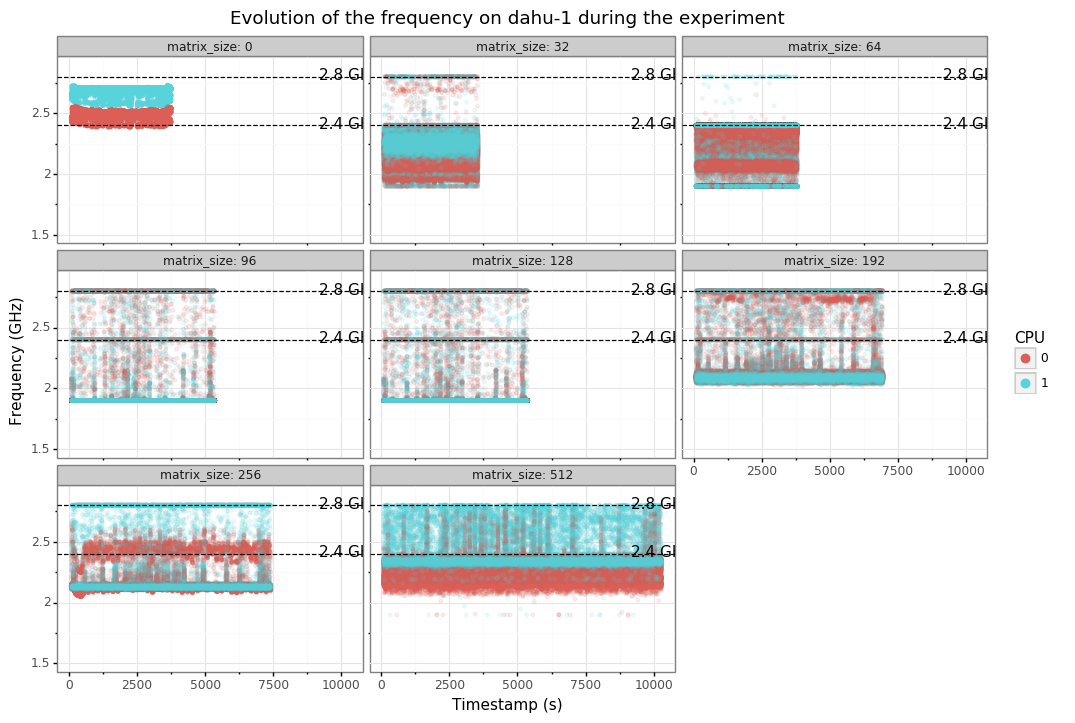

<ggplot: (8794307216823)>


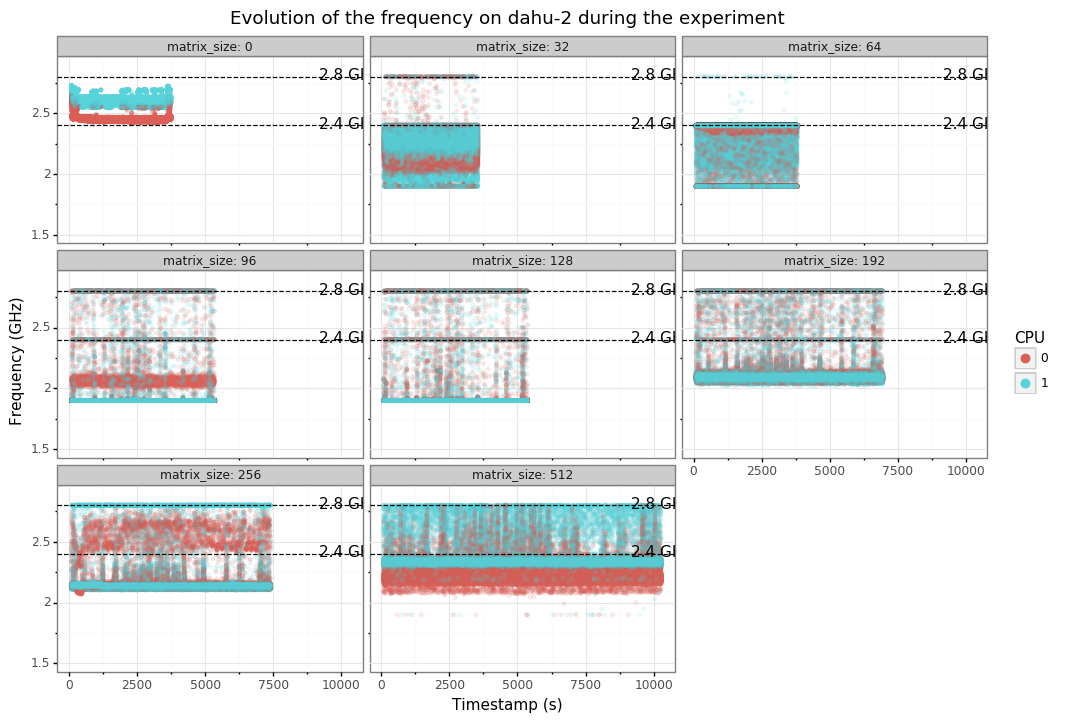

<ggplot: (8794129253440)>


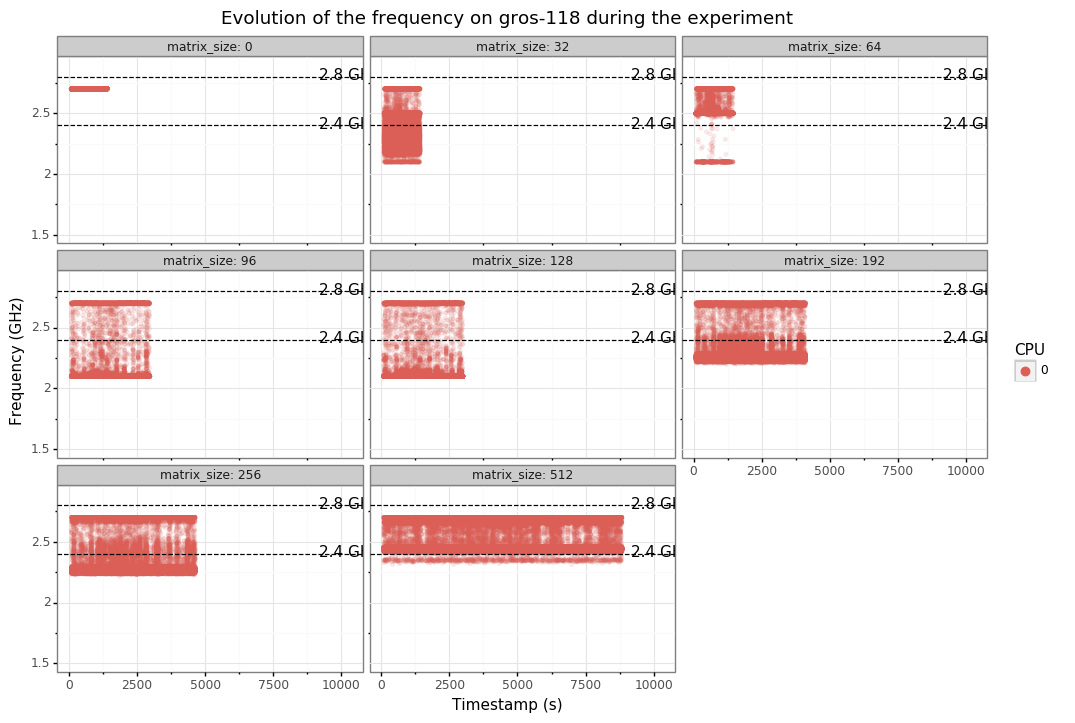

<ggplot: (8794130551542)>


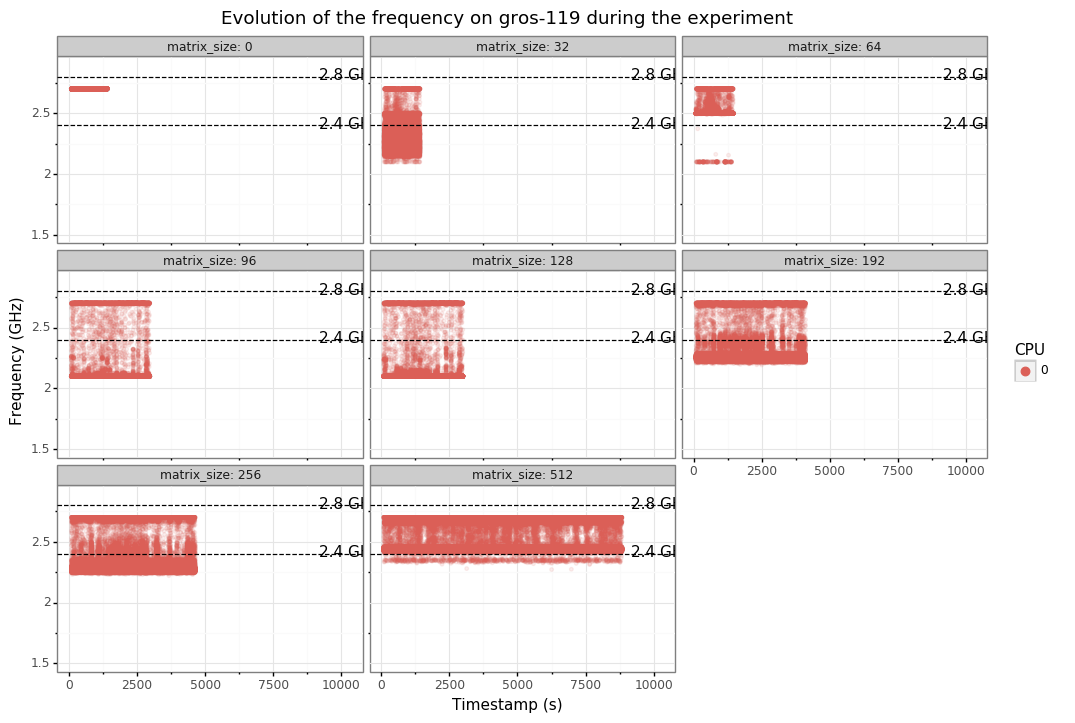

<ggplot: (-9223363242442324157)>


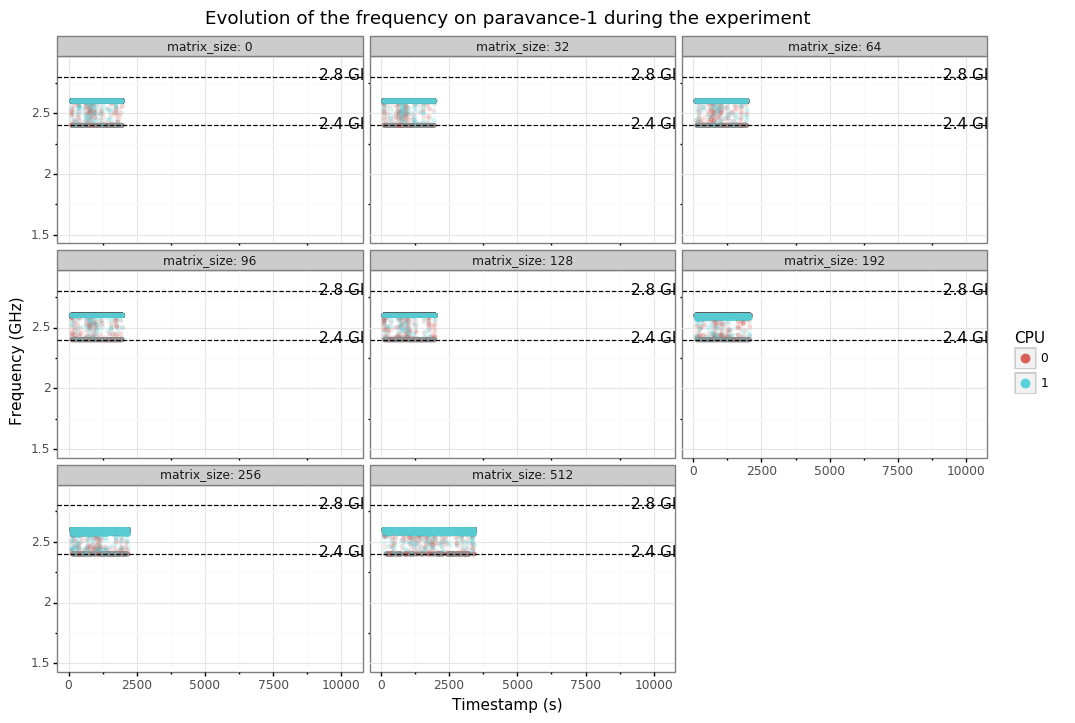

<ggplot: (8794245434607)>


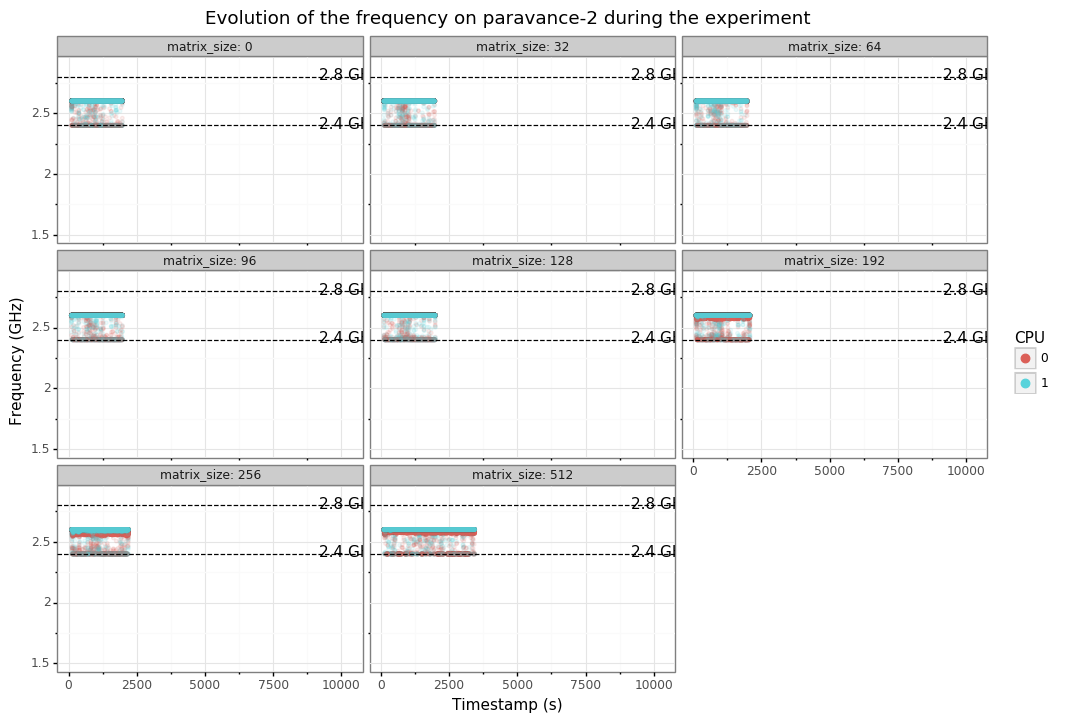

<ggplot: (8794414505683)>


In [16]:
for hostname in sorted(monitoring.hostname.unique()):
    print(ggplot(monitoring[(monitoring.in_exp) & (monitoring.hostname == hostname) & (monitoring.kind == 'frequency')])
        + aes(x='timestamp', y='value', color='factor(cpu)')
        + geom_point(alpha=0.1, size=1)
        + theme_bw()
        + labs(x='Timestamp (s)', y='Frequency (GHz)', color='CPU')
        + ggtitle(f'Evolution of the frequency on {hostname} during the experiment')
        + guides(colour = guide_legend(override_aes = {'alpha': 1, 'size': 3}))
        + geom_hline(yintercept=2.4, linetype='dashed')
        + annotate('text', label='2.4 GHz', x=monitoring[monitoring.in_exp].timestamp.max(), y=2.41)
        + geom_hline(yintercept=2.8, linetype='dashed')
        + annotate('text', label='2.8 GHz', x=monitoring[monitoring.in_exp].timestamp.max(), y=2.81)
        + expand_limits(y=[1.5, 2.9])
        + facet_wrap('matrix_size', labeller='label_both')
    )